:::{currentmodule} tskit
:::


(sec_data_model)=

# Data model

The `tskit` library deals with sets of sampled genome sequences through storage
and analysis of their shared genetic ancestry. This genealogical ancestry (sometimes
known as an Ancestral Recombination Graph) is stored concisely in `tskit` in the 
"succinct tree sequence" format, which comprises a collection of easy-to-understand
tables. This page documents the structure of the tables and encoding of table data,
as well as the encoding of the correlated genetic trees that can be extracted from
a `tskit` tree sequence.

We begin by defining the the structure of the tables in the {ref}`sec_table_definitions`
section. The {ref}`sec_data_model_data_encoding` section then describe how data is
stored in those tables (also see the {ref}`sec_file_formats`
chapter). The {ref}`sec_data_model_tree_structure` section then
describes the encoding of the trees that are generated from the {class}`NodeTable`
and {class}`EdgeTable`. Finally, we describe how genotype data arises from tree
structure, especially how we can incorporate the idea of missing data.

(sec_table_definitions)=

## Table definitions

(sec_table_types_definitions)=

### Table types

A tree sequence can be stored in a collection of eight tables:
{ref}`Node <sec_node_table_definition>`,
{ref}`Edge <sec_edge_table_definition>`,
{ref}`Individual <sec_individual_table_definition>`,
{ref}`Site <sec_site_table_definition>`,
{ref}`Mutation <sec_mutation_table_definition>`,
{ref}`Migration <sec_migration_table_definition>`,
{ref}`Population <sec_population_table_definition>`, and
{ref}`Provenance <sec_provenance_table_definition>`.
The Node and Edge tables store the genealogical
relationships that define the trees, and the Individual table
describes how multiple genomes are grouped within individuals;
the Site and Mutation tables describe where mutations fall
on the trees; the Migration table describes how lineages move across space;
and the Provenance table contains information on where the data came from.
Only Node and Edge tables are necessary to encode the genealogical trees;
Sites and Mutations are optional but necessary to encode polymorphism
(sequence) data; the remainder are optional.
In the following sections we define these components of a tree sequence in
more detail.

(sec_node_table_definition)=

#### Node Table

A **node** defines a monoploid set of chromosomes (a "genome") of a specific
individual that was born at some time in the past: the set of
chromosomes inherited from a particular one of the individual's parents.
(See {ref}`sec_nodes_or_individuals` for more discussion.)
Every vertex in the marginal trees of a tree sequence corresponds
to exactly one node, and a node may be present in many trees. The
node table contains five columns, of which `flags` and `time` are
mandatory:


| Column        |  Type       |  Description                           |
| :------------ | ----------- | -------------------------------------: |
| flags         |  uint32     |  Bitwise flags.                        |
| time          |  double     |  Birth time of node.                   |
| population    |  int32      |  Birth population of node.             |
| individual    |  int32      |  The individual the node belongs to.   |
| metadata      |  binary     |  Node {ref}`sec_metadata_definition`.  |

The `time` column records the birth time of the individual in question,
and is a floating point value. Similarly,
the `population` column records the ID of the population where this
individual was born. If not provided, `population` defaults to the
null ID (-1). Otherwise, the population ID must refer to a row in the
{ref}`sec_population_table_definition`.
The `individual` column records the ID of the
{ref}`Individual <sec_individual_table_definition>`
individual that this node belongs to. If specified, the ID must refer
to a valid individual. If not provided, `individual`
defaults to the null ID (-1).

The `flags` column stores information about a particular node, and
is composed of 32 bitwise boolean values. Currently, the only flag defined
is `NODE_IS_SAMPLE = 1`, which defines the *sample* status of nodes. Marking
a particular node as a "sample" means, for example, that the mutational state
of the node will be included in the genotypes produced by
{meth}`TreeSequence.variants`.

Bits 0-15 (inclusive) of the `flags` column are reserved for internal use by
`tskit` and should not be used by applications for anything other
than the purposes documented here. Bits 16-31 (inclusive) are free for applications
to use for any purpose and will not be altered or interpreteted by
`tskit`.

See the {ref}`sec_node_requirements` section for details on the properties
required for a valid set of nodes.

For convenience, the {ref}`text format <sec_text_file_format>` for nodes
decomposes the `flags` value into its separate values. Thus, in the
text format we have a column for `is_sample`, which corresponds to the
`flags` column in the underlying table. As more flags values are
defined, these will be added to the text file format.

The `metadata` column provides a location for client code to store
information about each node. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

:::{note}
The distinction between `flags` and `metadata` is that flags
holds information about a node that the library understands, whereas
metadata holds information about a node that the library *does not*
understand. Metadata is for storing auxiliarly information that is
not necessary for the core tree sequence algorithms.
:::


(sec_individual_table_definition)=

#### Individual Table

An **individual** defines how nodes (which can be seen
as representing single chromosomes) group together in a polyploid individual.
The individual table contains three columns, of which only `flags` is mandatory.

| Column        | Type       | Description                                |
| :------------ | ---------- | -----------------------------------------: |
| flags         | uint32     | Bitwise flags.                             |
| location      | double     | Location in arbitrary dimensions.          |
| parents       | int32      | Ids of parent individuals.                 |
| metadata      | binary     | Individual {ref}`sec_metadata_definition`. |

See the {ref}`sec_individual_requirements` section for details on the properties
required for a valid set of individuals.

The `flags` column stores information about a particular individual, and
is composed of 32 bitwise boolean values. Currently, no flags are
defined.

Bits 0-15 (inclusive) of the `flags` column are reserved for internal use by
`tskit` and should not be used by applications for anything other
than the purposes documented here. Bits 16-31 (inclusive) are free for applications
to use for any purpose and will not be altered or interpreteted by
`tskit`.

The `location` column stores the location of an individual in arbitrary
dimensions. This column is {ref}`ragged <sec_encoding_ragged_columns>`, and
so different individuals can have locations with different dimensions (i.e.,
one individual may have location `[]` and another `[0, 1, 0]`. This could
therefore be used to store other quantities (e.g., phenotype).

The `parents` column stores the ids of other individuals that are the parents of
an individual. This column is {ref}`ragged <sec_encoding_ragged_columns>` such that an
individual can have any number of parents.

The `metadata` column provides a location for client code to store
information about each individual. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

:::{note}
The distinction between `flags` and `metadata` is that flags
holds information about a individual that the library understands, whereas
metadata holds information about a individual that the library *does not*
understand. Metadata is for storing auxiliarly information that is
not necessary for the core tree sequence algorithms.
:::


(sec_edge_table_definition)=

#### Edge Table

An **edge** defines a parent-child relationship between a pair of nodes
over a specific sequence interval. The edge table contains five columns,
all of which are mandatory except `metadata`:

| Column        | Type       | Description                                |
| :------------ | ---------- | -----------------------------------------: |
| left          | double     | Left coordinate of the edge (inclusive).   |
| right         | double     | Right coordinate of the edge (exclusive).  |
| parent        | int32      | Parent node ID.                            |
| child         | int32      | Child node ID.                             |
| metadata      | binary     | Node {ref}`sec_metadata_definition`.       |

Each row in an edge table describes a half-open genomic interval `[left, right)`
over which the `child` inherited from the given `parent`.
The `left` and `right` columns are defined using double precision
floating point values. The `parent` and `child`
columns specify integer IDs in the associated {ref}`sec_node_table_definition`.

The `metadata` column provides a location for client code to store
information about each edge. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

See the {ref}`sec_edge_requirements` section for details on the properties
required for a valid set of edges.


(sec_site_table_definition)=

#### Site Table

A **site** defines a particular location along the genome in which
we are interested in observing the allelic state. The site table
contains three columns, of which `position` and `ancestral_state`
are mandatory.

| Column          | Type       | Description                                |
| :-------------- | ---------- | -----------------------------------------: |
| position        | double     | Position of site in genome coordinates.    |
| ancestral_state | text       | The state at the root of the tree.         |
| metadata        | binary     | Site {ref}`sec_metadata_definition`.       |

The `position` column is a floating point value defining the location
of the site in question along the genome.

The `ancestral_state` column specifies the allelic state at the root
of the tree, thus defining the state that nodes inherit if no mutations
intervene. The column stores text character data of arbitrary length.

The `metadata` column provides a location for client code to store
information about each site. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

See the {ref}`sec_site_requirements` section for details on the properties
required for a valid set of sites.


(sec_mutation_table_definition)=

#### Mutation Table

A **mutation** defines a change of allelic state on a tree at a particular site.
The mutation table contains five columns, of which `site`, `node` and
`derived_state` are mandatory.

| Column          | Type       | Description                                    |
| :-------------- | ---------- | ---------------------------------------------: |
| site            | int32      | The ID of the site the mutation occurs at.     |
| node            | int32      | The node this mutation occurs at.              |
| parent          | int32      | The ID of the parent mutation.                 |
| time            | double     | Time at which the mutation occurred.           |
| derived_state   | char       | The allelic state resulting from the mutation. |
| metadata        | binary     | Mutation {ref}`sec_metadata_definition`.       |

The `site` column is an integer value defining the ID of the
{ref}`site <sec_site_table_definition>` at which this mutation occurred.

The `node` column is an integer value defining the ID of the
first {ref}`node <sec_node_table_definition>` in the tree below this mutation.

The  `time` column is a double precision floating point value recording how long ago
the mutation happened.

The `derived_state` column specifies the allelic state resulting from the mutation,
thus defining the state that the `node` and any descendant nodes in the
subtree inherit unless further mutations occur. The column stores text
character data of arbitrary length.

The `parent` column is an integer value defining the ID of the mutation whose
allelic state this mutation replaced. If there is no mutation at the
site in question on the path back to root, then this field is set to the
null ID (-1). (The `parent` column is only required in situations
where there are multiple mutations at a given site. For
"infinite sites" mutations, it can be ignored.)

The `metadata` column provides a location for client code to store
information about each site. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

See the {ref}`sec_mutation_requirements` section for details on the properties
required for a valid set of mutations.


(sec_migration_table_definition)=

#### Migration Table

In simulations, trees can be thought of as spread across space, and it is
helpful for inferring demographic history to record this history.
Migrations are performed by individual ancestors, but most likely not by an
individual whose genome is tracked as a `node` (as in a discrete-deme model they are
unlikely to be both a migrant and a most recent common ancestor).  So,
`tskit` records when a segment of ancestry has moved between
populations. This table is not required, even if different nodes come from
different populations.

| Column     | Type     | Description                                            |
| :--------- | -------- | -----------------------------------------------------: |
| left       | double   | Left coordinate of the migrating segment (inclusive).  |
| right      | double   | Right coordinate of the migrating segment (exclusive). |
| node       | int32    | Node ID.                                               |
| source     | int32    | Source population ID.                                  |
| dest       | int32    | Destination population ID.                             |
| time       | double   | Time of migration event.                               |
| metadata   | binary   | Migration {ref}`sec_metadata_definition`.              |


The `left` and `right` columns are floating point values defining the
half-open segment of genome affected. The `source` and `dest` columns
record the IDs of the respective populations. The `node` column records the
ID of the node that was associated with the ancestry segment in question
at the time of the migration event. The `time` column is holds floating
point values recording the time of the event.

The `metadata` column provides a location for client code to store
information about each migration. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

See the {ref}`sec_migration_requirements` section for details on the properties
required for a valid set of mutations.


(sec_population_table_definition)=

#### Population Table

A **population** defines a grouping of individuals that a node can
be said to belong to.

The population table contains one column, `metadata`.

| Column     | Type     | Description                                |
| :--------- | -------- | -----------------------------------------: |
| metadata   | binary   | Population {ref}`sec_metadata_definition`. |


The `metadata` column provides a location for client code to store
information about each population. See the {ref}`sec_metadata_definition` section for
more details on how metadata columns should be used.

See the {ref}`sec_population_requirements` section for details on the properties
required for a valid set of populations.


(sec_provenance_table_definition)=

#### Provenance Table

:::{todo}
Document the provenance table.
:::

| Column    | Type  | Description                                                             |
| :-------- | ----- | ----------------------------------------------------------------------: |
| timestamp | char  | Timestamp in [ISO-8601](https://en.wikipedia.org/wiki/ISO_8601) format. |
| record    | char  | Provenance record.                                                      |


(sec_metadata_definition)=

### Metadata

Each table (excluding provenance) has a metadata column for storing and passing along
information that tskit does not use or interpret. See {ref}`sec_metadata` for details.
The metadata columns are {ref}`binary columns <sec_tables_api_binary_columns>`.

When using the {ref}`sec_text_file_format`, to ensure that metadata can be safely
interchanged, each row is [base 64 encoded](https://en.wikipedia.org/wiki/Base64).
Thus, binary information can be safely printed and exchanged, but may not be
human readable.

The tree sequence itself also has metadata stored as a byte array.


(sec_valid_tree_sequence_requirements)=

### Valid tree sequence requirements

Arbitrary data can be stored in tables using the classes in the
{ref}`sec_tables_api`. However, only a {class}`TableCollection`
that fulfils a set of requirements represents
a valid {class}`TreeSequence` object which can be obtained
using the {meth}`TableCollection.tree_sequence` method. In this
section we list these requirements, and explain their rationale.
Violations of most of these requirements are detected when the
user attempts to load a tree sequence via {func}`tskit.load` or
{meth}`TableCollection.tree_sequence`, raising an informative
error message. Some more complex requirements may not be detectable at load-time,
and errors may not occur until certain operations are attempted.
These are documented below.

The Python API also provides tools that can transform a collection of
tables into a valid collection of tables, so long as they are logically
consistent, see {ref}`sec_tables_api_creating_valid_tree_sequence`.


(sec_individual_requirements)=

#### Individual requirements

Individuals are a basic type in a tree sequence and are not defined with
respect to any other tables. Individuals can have a reference to their parent
individuals, if present these references must be valid or null (-1).

A valid tree sequence does not require individuals to be sorted in any
particular order, and sorting a set of tables using {meth}`TableCollection.sort`
has no effect on individuals. However, individuals can be optionally sorted
using {meth}`TableCollection.sort_individuals`.

(sec_node_requirements)=

#### Node requirements

Given a valid set of individuals and populations, the requirements for
each node are:

- `population` must either be null (-1) or refer to a valid population ID;
- `individual` must either be null (-1) or refer to a valid individual ID.

An ID refers to a zero-indexed row number in the relevant table,
and so is "valid" if is between 0 and one less than the number of rows in the relevant table.

There are no requirements regarding the ordering of nodes with respect to time.

Sorting a set of tables using {meth}`TableCollection.sort`
has no effect on nodes.


(sec_edge_requirements)=

#### Edge requirements

Given a valid set of nodes and a sequence length {math}`L`, the simple
requirements for each edge are:

- We must have {math}`0 \leq` `left` {math}`<` `right` {math}`\leq L`;
- `parent` and `child` must be valid node IDs;
- `time[parent]` > `time[child]`;
- edges must be unique (i.e., no duplicate edges are allowed).

The first requirement simply ensures that the interval makes sense. The
third requirement ensures that we cannot have loops, since time is
always increasing as we ascend the tree.

To ensure a valid tree sequence there is one further requirement:

- The set of intervals on which each node is a child must be disjoint.

This guarantees that we cannot have contradictory edges (i.e.,
where a node `a` is a child of both `b` and `c`), and ensures that
at each point on the sequence we have a well-formed forest of trees.

In the interest of algorithmic efficiency, edges must have the following
sortedness properties:

- All edges for a given parent must be contiguous;
- Edges must be listed in nondecreasing order of `parent` time;
- Within the edges for a given `parent`, edges must be sorted
  first by `child` ID and then by `left` coordinate.

Violations of these requirements are detected at load time.
The {meth}`TableCollection.sort` method will ensure that these sortedness
properties are fulfilled.


(sec_site_requirements)=

#### Site requirements

Given a valid set of nodes and a sequence length {math}`L`, the simple
requirements for a valid set of sites are:

- We must have {math}`0 \leq` `position` {math}`< L`;
- `position` values must be unique.

For simplicity and algorithmic efficiency, sites must also:

- Be sorted in increasing order of `position`.

Violations of these requirements are detected at load time.
The {meth}`TableCollection.sort` method ensures that sites are sorted
according to these criteria.


(sec_mutation_requirements)=

#### Mutation requirements

Given a valid set of nodes, edges and sites, the
requirements for a valid set of mutations are:

- `site` must refer to a valid site ID;
- `node` must refer to a valid node ID;
- `time` must either be `UNKNOWN_TIME` (a NAN value which indicates
  the time is unknown) or be a finite value which is greater or equal to the
  mutation `node`'s `time`, less than the `node` above the mutation's
  `time` and equal to or less than the `time` of the `parent` mutation
  if this mutation has one. If one mutation on a site has `UNKNOWN_TIME` then
  all mutations at that site must, as a mixture of known and unknown is not valid.
- `parent` must either be the null ID (-1) or a valid mutation ID within the
  current table

Furthermore,

- If another mutation occurs on the tree above the mutation in
  question, its ID must be listed as the `parent`.

For simplicity and algorithmic efficiency, mutations must also:

- be sorted by site ID;
- when there are multiple mutations per site, mutations should be ordered by
  decreasing time, if known, and parent mutations must occur
  **before** their children (i.e. if a mutation with ID {math}`x` has
  `parent` with ID {math}`y`, then we must have {math}`y < x`).

Violations of these sorting requirements are detected at load time.
The {meth}`TableCollection.sort` method ensures that mutations are sorted
according site ID, but does not at present enforce that mutations occur
after their parent mutations.

Silent mutations (i.e., mutations for which the ancestral and derived
states are the same) are allowed.
For example, if we have a site with ancestral state
of "A" and a single mutation with derived state "A", then this
mutation does not result in any change of state.
(This addition was made in release C_0.99.11.)

:::{note}
As `tskit.UNKNOWN_TIME` is implemented as a `NaN` value, tests for equality
will always fail. Use `tskit.is_unknown_time` to detect unknown values.
:::


(sec_migration_requirements)=

#### Migration requirements

Given a valid set of nodes and edges, the requirements for a value set of
migrations are:

- `left` and `right` must lie within the tree sequence coordinate space (i.e.,
  from 0 to `sequence_length`).
- `time` must be strictly between the time of its `node` and the time of any
  ancestral node from which that node inherits on the segment `[left, right)`.
- The `population` of any such ancestor matching `source`, if another
  `migration` does not intervene.

To enable efficient processing, migrations must also be:

- Sorted by nondecreasing `time` value.

Note in particular that there is no requirement that adjacent migration records
should be "squashed". That is, we can have two records `m1` and `m2`
such that `m1.right` = `m2.left` and with the `node`, `source`,
`dest` and `time` fields equal. This is because such records will usually
represent two independent ancestral segments migrating at the same time, and
as such squashing them into a single record would result in a loss of information.


(sec_population_requirements)=

#### Population requirements

There are no requirements on a population table.


(sec_provenance_requirements)=

#### Provenance requirements

The `timestamp` column of a provenance table should be in
[ISO-8601](https://en.wikipedia.org/wiki/ISO_8601) format.

The `record` should be valid JSON with structure defined in the Provenance
Schema section (TODO).


(sec_table_indexes)=

### Table indexes

To efficiently iterate over the trees in a tree sequence, `tskit` uses
indexes built on the edges. To create a tree sequence from a table collection
the tables must be indexed; the {meth}`TableCollection.build_index` method
can be used to create an index on a table collection if necessary.

:::{todo}
Add more details on what the indexes actually are.
:::

(sec_data_model_data_encoding)=

## Data encoding

In this section we describe the high-level details of how data is encoded in
tables. Tables store data in a **columnar** manner. In memory, each
table is organised as a number of blocks of contiguous storage, one for
each column. There are many advantages to this approach, but the key
property for us is that allows for very efficient transfer of data
in and out of tables. Rather than inserting data into tables row-by-row
(which can be done in Python
{ref}`using the add_row methods<sec_tables_api_accessing_table_data>`), it is much
more efficient to add many rows at the same time by providing pointers to blocks of
contiguous memory. By taking this approach, we can work with tables containing
gigabytes of data very efficiently.

For instance, in the {ref}`sec_python_api` we can use the
[numpy Array API](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.html)
to allow us to define and work with numeric arrays of the required types.
Node IDs, for example, are defined using 32 bit integers. Thus, the
`parent` column of an {ref}`sec_edge_table_definition`'s with `n` rows
is a block `4n` bytes.

This approach is very straightforward for columns in which each row contains
a fixed number of values. However, dealing with columns containing a
**variable** number of values is more problematic.


(sec_encoding_ragged_columns)=

### Encoding ragged columns

A **ragged** column is a column in which the rows are not of a fixed length.
For example, {ref}`sec_metadata_definition` columns contain binary of data of arbitrary
length. To encode such columns in the tables API, we store **two** columns:
one contains the flattened array of data and another stores the **offsets**
of each row into this flattened array. Consider an example:

In [1]:
import tskit

s = tskit.SiteTable()
s.add_row(0, "A")
s.add_row(0, "")
s.add_row(0, "TTT")
s.add_row(0, "G")
s

id,position,ancestral_state,metadata
0,0,A,
1,0,,
2,0,TTT,
3,0,G,


In this example we create a {ref}`sec_site_table_definition` with four rows,
and then display this table. We can see that the second row has the
empty string as its `ancestral_state`, and the third row's
`ancestral_state` is `TTT`. Now let's print out the columns:

In [2]:
print("Ancestral state (numerical): ", s.ancestral_state)
print("Ancestral state (as bytes): ", s.ancestral_state.tobytes())
print("Ancestral state offsets: ", s.ancestral_state_offset)

Ancestral state (numerical):  [65 84 84 84 71]
Ancestral state (as bytes):  b'ATTTG'
Ancestral state offsets:  [0 1 1 4 5]


When we print out the tables `ancestral_state`
column, we see that its a numpy array of length 5: this is the
flattened array of [ASCII encoded](https://en.wikipedia.org/wiki/ASCII)
values for these rows. When we decode these bytes using the
numpy {meth}`tobytes<numpy:numpy.ndarray.tobytes>` method, we get the string 'ATTTG'.
This flattened array can now be transferred efficiently in memory like any other column
We then use the `ancestral_state_offset` column to allow us find the individual rows.
For a row `j`:

    ancestral_state[ancestral_state_offset[j]: ancestral_state_offset[j + 1]]

gives us the array of bytes for the ancestral state in that row. For example, here is
row 2:

In [3]:
s.ancestral_state[s.ancestral_state_offset[2]: s.ancestral_state_offset[3]].tobytes()

b'TTT'

For a table with `n` rows, any offset column must have `n + 1`
values, the first of which is always `0`. The values in this column must be
nondecreasing, and cannot exceed the length of the ragged column in question.


(sec_data_model_reference_sequence)=

## Reference sequence

Along with the topology and site information stored in the tskit tree
sequence, we can also optionally store an associated reference sequence.
Reference sequences are flexible, and can consist simply of some
metadata recording which assembly build a tree sequence uses, or
storing the entire sequence itself.

:::{warning}
Reference sequence support in tskit is preliminary. Reference sequence
data can be stored and accessed via the C API. Support in the Python
API is limited to usage in {meth}`.TreeSequence.alignments` and
related methods, where it provides the default values for nucleotide
positions between {ref}`sites<sec_data_model_definitions_site>`.
:::

(sec_data_model_tree_structure)=

## Tree structure

(sec_data_model_quintuply_linked_trees)=

### Quintuply linked trees

Tree structure in `tskit` is encoded internally as a "quintuply
linked tree", a generalisation of the triply linked tree encoding
used by Knuth and others. Nodes are represented by their integer
IDs, and their relationships to other nodes are recorded in the
`parent`, `left_child`, `right_child`, `left_sib` and
`right_sib` arrays. For example, consider the following tree
and its associated arrays:

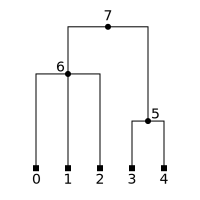

In [4]:
import io

import tskit
from IPython.display import SVG

nodes = """\
id      is_sample   time
0       1           0
1       1           0
2       1           0
3       1           0
4       1           0
5       0           1
6       0           2
7       0           3
"""
edges = """\
left    right   parent  child
0       60      5       4,3
0       40      6       2
0       60      6       1,0
20      40      6       5
0       20      7       5
40      60      7       5
0       60      7       6
40      60      7       2
"""
ts = tskit.load_text(
    nodes=io.StringIO(nodes), edges=io.StringIO(edges), strict=False
)

SVG(ts.first().draw_svg(time_scale="rank"))

In [5]:
from IPython.display import HTML

def html_quintuple_table(ts, show_virtual_root=False, show_convenience_arrays=False):
    tree = ts.first()
    columns = ["node", "parent", "left_child", "right_child", "left_sib", "right_sib"]
    convenience_arrays = ["num_children", "edge"]
    if show_convenience_arrays:
        columns += convenience_arrays
    data = {k:[] for k in columns}
    for u in sorted(tree.nodes(tree.virtual_root if show_virtual_root else None)):
        for colname in columns:
            data[colname].append(u if colname == "node" else getattr(tree, colname)(u))
    html = "<tr>"
    for colname in columns:
        html += f"<th>{colname}</th>"
    html += "</tr>"
    for u in range(len(data["node"])):
        html += "<tr>" if u < ts.num_nodes else "<tr style='font-style: italic; color:red'>"
        for colname in columns:
            html += f"<td>{data[colname][u]}</td>"
        html += "</tr>"
    return "<table>" + html + "</table>"

HTML(html_quintuple_table(ts))

node,parent,left_child,right_child,left_sib,right_sib
0,6,-1,-1,-1,1
1,6,-1,-1,0,2
2,6,-1,-1,1,-1
3,5,-1,-1,-1,4
4,5,-1,-1,3,-1
5,7,3,4,-1,6
6,7,0,2,5,-1
7,-1,5,6,-1,-1


Each node in the tree corresponds to a row in this table, and
the columns are the individual arrays recording the quintuply linked
structure. Thus, we can see that the parent of nodes `0`, `1`, and `2`
is `6`. Similarly, the left child of `6` is `0` and the
right child of `6` is `2`. The `left_sib` and `right_sib` arrays
then record each nodes sibling on its left or right, respectively;
hence the right sib of `0` is `1`, and the right sib of `1` is `2`.
Thus, sibling information allows us to efficiently support trees
with arbitrary numbers of children. In each of the five pointer arrays,
the null node (-1) is used to indicate the end of a path; thus,
for example, the parent of `7` and left sib of `0` are null.

Please see this {ref}`example <sec_c_api_examples_tree_traversals>` for
details of how to use the quintuply linked structure in the C API.

:::{note}
For many applications we do not need the quintuply linked trees,
and (for example) the `left_sib` and `right_child` arrays can be
ignored. The reason for using a quintuply instead of triply linked
encoding is that it is not possible to efficiently update the trees
as we move along the sequence without the quintuply linked structure.
:::

:::{warning}
The left-to-right ordering of nodes is determined by the order
in which edges are inserted into the tree during iteration along the sequence.
Thus, if we arrive at the same tree by iterating from different directions,
the left-to-right ordering of nodes may be different! The specific
ordering of the children of a node should therefore not be depended on.
:::

### Convenience arrays
 
Similar to the five arrays representing the {ref}`quintuply linked tree<sec_data_model_quintuply_linked_trees>`,
convenience arrays track information on each node in the tree. These arrays are not essential to 
represent the trees within a tree sequence. However, they can be useful for
specific algorithms (e.g. when computing tree (im)balance metrics). Two 
convenience arrays have been implemented so far: 
{attr}`Tree.num_children_array` and {attr}`Tree.edge_array`.

Here is the table above with the convenience arrays also shown:

In [6]:
HTML(html_quintuple_table(ts, show_convenience_arrays=True))

node,parent,left_child,right_child,left_sib,right_sib,num_children,edge
0,6,-1,-1,-1,1,0,2
1,6,-1,-1,0,2,0,3
2,6,-1,-1,1,-1,0,4
3,5,-1,-1,-1,4,0,0
4,5,-1,-1,3,-1,0,1
5,7,3,4,-1,6,2,7
6,7,0,2,5,-1,3,9
7,-1,5,6,-1,-1,2,-1


(sec_data_model_tree_roots)=

### Roots

The roots of a tree are defined as the unique endpoints of upward paths
starting from sample nodes ({ref}`isolated<sec_data_model_tree_isolated_nodes>`
sample nodes also count as roots). Thus, trees can have multiple roots in `tskit`.
For example, if we delete the edge joining `6` and `7` in the previous
example, we get a tree with two roots:

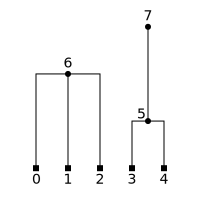

In [7]:
tables = ts.dump_tables()
tables.edges.truncate(ts.num_edges - 1)
ts_multiroot = tables.tree_sequence()
SVG(ts_multiroot.first().draw_svg(time_scale="rank"))

Note that in tree sequence terminology, this should *not* be thought
of as two separate trees, but as a single multi-root "tree", comprising
two unlinked topologies. This fits with the definition of a tree
in a tree sequence: a tree describes the ancestry of the same
fixed set of sample nodes at a single position in the genome. In the
picture above, *both* the left and right hand topologies are required
to describe the genealogy of samples 0..4 at this position.

Here's what it looks like for an entire tree sequence:

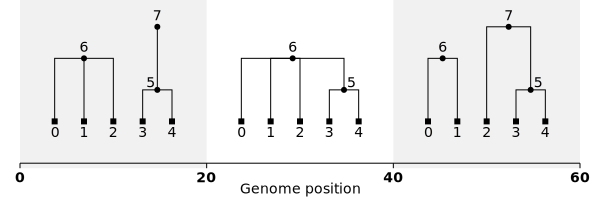

In [8]:
SVG(ts_multiroot.draw_svg(time_scale="rank"))

This tree sequence consists of three trees. The first tree, which applies from
position 0 to 20, is the one used in our example. As we saw, removing the edge
connecting node 6 to node 7 has created a tree with 2 roots (and thus 2
unconnected topologies in a single tree). In contrast, the second tree, from
position 20 to 40, has a single root. Finally the third tree, from position
40 to 60, again has two roots.

(sec_data_model_tree_virtual_root)=

#### The virtual root

To access all the {attr}`~Tree.roots` in a tree, tskit uses a special additional node
called the **virtual root**. This is primarily a bookkeeping device, and
can normally be ignored: it is not plotted in any visualizations and
does not exist as an independent node in the node table.
However, the virtual root can be useful in certain algorithms because its
children are defined as all the "real" roots in a tree. Hence by
descending downwards from the virtual root, it is possible
to access the entire genealogy at a given site, even in a multi-root
tree. In the quintuply linked tree encoding, the virtual root appears as an
extra element at the end of each of the tree arrays. Here's the same table
as before but with the virtual root also shown, using red italics to
emphasise that it is not a "real" node:

In [9]:
HTML(html_quintuple_table(ts_multiroot, show_virtual_root=True))

node,parent,left_child,right_child,left_sib,right_sib
0,6,-1,-1,-1,1
1,6,-1,-1,0,2
2,6,-1,-1,1,-1
3,5,-1,-1,-1,4
4,5,-1,-1,3,-1
5,7,3,4,-1,-1
6,-1,0,2,-1,7
7,-1,5,5,6,-1
8,-1,6,7,-1,-1


You can see that the virtual root (node 8) has 6 as its left child and 7
as its right child. Importantly, though, this is an asymmetric
relationship: the parent of the "real" roots 6 and 7 is null
(-1) and *not* the virtual root. Hence when we ascend up the tree from the
sample nodes to their parents, we stop at the "real" roots, and never
encounter the virtual root.

Because the virtual root can be useful in some algorithms, it can
optionally be returned in traversal orders (see {meth}`.Tree.nodes`).
The following properties apply:

- All trees in a tree sequence share the same virtual root.
- The virtual root's ID is always equal to the number of nodes in the tree sequence
  (i.e. the length of the node table). However, there is **no corresponding row**
  in the node table, and any attempts to access information about the
  virtual root via either the tree sequence or tables APIs will fail with
  an out-of-bounds error.
- The parent and siblings of the virtual root are null.
- The time of the virtual root is defined as positive infinity (if
  accessed via {meth}`.Tree.time`). This is useful in defining the
  time-based node traversal orderings.
- The virtual root is the parent of no other node---roots do **not**
  have parent pointers to the virtual root.


(sec_data_model_tree_isolated_nodes)=

### Isolated nodes

In a tree, it is possible for a node to have no children and no parent. Such a node is
said to be *isolated*, meaning that we don't know anything about its relationships
over a specific genomic interval. This is commonly true for ancestral genomes, which
often have large regions that have
not been inherited by any of the {ref}`sample nodes<sec_data_model_definitions_sample>`
in the tree sequence, and therefore regions about which we know nothing. This is true,
for example, of node 7 in the middle tree of our previous example, which is why it is
not plotted on that tree:

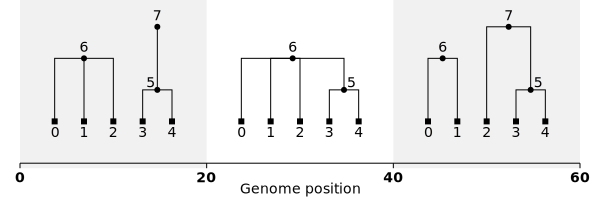

Node 7 is not isolated from position 0.0 to 20.0
Node 7 is isolated from position 20.0 to 40.0
Node 7 is not isolated from position 40.0 to 60.0


In [10]:
display(SVG(ts_multiroot.draw_svg(time_scale="rank")))
for tree in ts_multiroot.trees():
    print(
        "Node 7",
        "is" if tree.is_isolated(7) else "is not",
        "isolated from position",
        tree.interval.left,
        "to",
        tree.interval.right,
    )

However, it is also possible for a {ref}`sample node<sec_data_model_definitions_sample>`
to be isolated. Unlike other nodes, isolated *sample* nodes are still considered as
being present on the tree (meaning they will still returned by the {meth}`Tree.nodes`
and {meth}`Tree.samples` methods): they are therefore plotted, but unconnected to any
other nodes. To illustrate, we can remove the edge from node 2 to node 7.

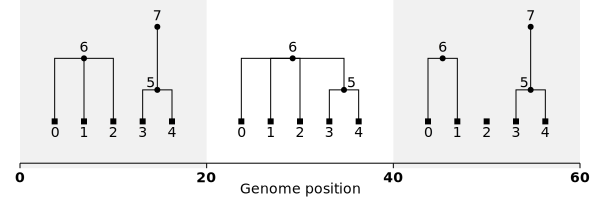

In [11]:
tables = ts_multiroot.dump_tables()
tables.edges.set_columns(
    **tables.edges[(tables.edges.parent != 7) | (tables.edges.child != 2)].asdict())
ts_isolated = tables.tree_sequence()
SVG(ts_isolated.draw_svg(time_scale="rank"))

The rightmost tree now contains an isolated sample node (node 2). Isolated
sample nodes count as one of the {ref}`sec_data_model_tree_roots` of the tree,
so that tree has three roots, one of which is node 2:

In [12]:
rightmost_tree = ts_isolated.at_index(-1)
print(rightmost_tree.num_roots, "roots in the rightmost tree, with IDs", rightmost_tree.roots)
print(
    "IDs of isolated samples in this tree:",
    [u for u in rightmost_tree.samples() if rightmost_tree.is_isolated(u)],
)

3 roots in the rightmost tree, with IDs [6, 2, 7]
IDs of isolated samples in this tree: [2]


In `tskit`, isolated sample nodes are closely associated with the encoding of
{ref}`sec_data_model_missing_data`.


(sec_data_model_tree_dead_leaves_and_branches)=

### Dead leaves and branches

In a `tskit` tree, a *leaf node* is defined as a node without any children. The
implications of this turn out to be slighly unintuitive, and so are worth briefly
documenting here. Firstly, the same node can be a leaf in one tree, and not a leaf
in the next tree along the tree sequence. Secondly all isolated nodes must be leaves
(as by definition they have no children). Thirdly sample nodes need not be leaves
(they could be "internal samples"); likewise leaf nodes need not be samples.

Node 7 in the example above provides a good case study. Note that it is a root node with
at least one child (i.e. not a leaf) in trees 0 and 2; in contrast in tree 1 it is
isolated. Strictly, because it is isolated in tree 1, it is also a leaf node there,
although it is not attached to a root, not a sample, and is therefore not plotted. In
this case, in that tree we can think of node 7 as a "dead leaf" (and we don't normally
plot dead leaves). In fact, in a large tree sequence of many trees, most ancestral nodes
will be isolated in any given tree, and therefore most nodes in such a tree will be of
this sort. However, these dead leaves are excluded from most calculations on trees,
because algorithms usually traverse the tree by starting at a root and working down,
or by starting at a sample and working up. Hence when we refer to the leaves of a tree,
it is usually shorthand for the leaves **on** the tree (that is, attached via branches,
to one of the the tree roots). Dead leaves are excluded from this definition.

Note that it is also possible to have trees in which there are "dead branches": that is
sections of topology which are not accessible from a root, and whose tips are all
dead leaves. Although valid, this is a relatively unusual state of affairs, and such
branches are not plotted by the standard {ref}`sec_tskit_viz` methods. The
{meth}`Tree.nodes` method will not, by default, traverse through dead branches, although
it can be made to do so by specifying the ID of a dead node as the root for traversal.


(sec_data_model_genetic_data)=

## Encoding genetic variation

Genetic variation is incorporated into a tree sequence by placing
{ref}`mutations<sec_mutation_table_definition>` at
{ref}`sites<sec_mutation_table_definition>` along the genome.
The genotypes of the different samples at each site
can be found by using the tree to calculate which mutations are inherited by
the different samples. This is the fundamental basis of how tree sequences
efficiently encode DNA sequences, and is explained in depth elsewhere
(e.g. {ref}`in the tutorials<sec_what_is_dna_data>`).

Below, we discuss some implications of this encoding in more detail, in particular
the way in which it can be used to model missing data.

(sec_data_model_missing_data)=

### Missing data

If, at a particular genomic position, a node is
{ref}`isolated<sec_data_model_tree_isolated_nodes>` *and* additionally has
no mutations directly above it, its genotype at that position is considered to be
unknown (however, if there is a mutation above an isolated node, it
can be thought of as saying directly what the genotype is, and so renders the
genotype at that position not missing).

By way of illustration, we'll use the {meth}`~TableCollection.delete_intervals` method
to remove all knowledge of the ancestry in the
middle portion of the previous example (say from position 15 to 45) sprinkle
on some mutations, and make sure there are sites at every position:

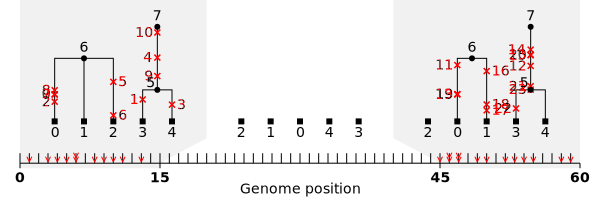

In [13]:
import numpy as np
import msprime

tables = msprime.sim_mutations(ts_isolated, rate=0.1, random_seed=123).dump_tables()
tables.delete_intervals([[15, 45]], simplify=False)
missing_sites = np.setdiff1d(np.arange(tables.sequence_length), tables.sites.position)
for pos in missing_sites:
    tables.sites.add_row(position=pos, ancestral_state="A")  # Add sites at every pos
tables.sort()
missing_ts = tables.tree_sequence()
SVG(missing_ts.draw_svg())

The middle section of the genome now has no ancestry at all, and therefore for any site
that is in this region, the genotypic state that it is assigned is a special value
`tskit.MISSING_DATA`, or `-1`. The {meth}`~TreeSequence.haplotypes()` method, which
outputs the actual allelic state for each sample, defaults to outputting an `N` at
these sites. Therefore where any sample node is isolated, the haplotype will show
an `N`, indicating the DNA sequence is unknown. This will be so not only in the
middle of all of the sample genomes, but also at the right hand end of the genome of
sample 2, as it is an isolated sample node in the rightmost tree:

In [14]:
for i, h in enumerate(missing_ts.haplotypes()):
    print(f"Sample {i}: {h}")

Sample 0: AAAGCCAATGAAATANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGAACGAATTGAACT
Sample 1: AGAGACAATAGAATANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTAAATAACCTGAACT
Sample 2: AGAGACGACAGAATANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Sample 3: AGATACGATAGCAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTCTACGAACAAAAAC
Sample 4: AGAGATGATAGCAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTCTACGAACAAAACC


See the {meth}`TreeSequence.variants` method and {class}`Variant` class for
more information on how missing data is represented in variant data.